## First benchmark

To benchmark: estimating disassembly indexes for increasing levels of complex peptidomes


        

In [1]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


enzymes1 = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)

enzymes2 = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "K+R protease"),
    ],
    [1],
    [1],
)


enzymes3 = enzyme_set(
    [
        enzyme({"V": 0.35, "I": 0.25, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)
protein = "MKAAVLTLAVLFLTGSQARHFWQQDEPPQSPWDRVKDLATVYVDVLKDSGRDYVSQFEGSALGKQLNLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMSKDLEEVKAKVQPYLDDFQKKWQEEMELYRQKVEPLRAELQEGARQKLHELQEKLSPLGEEMRDRARAHVDALRTHLAPYSDELRQRLAARLEALKENGGARLAEYHAKATEHLSTLSEKAKPALEDLRQGLLPVLESFKVSFLSALEEYTKKLNTQ"

In [2]:
from disassembly.benchmark import Benchmark

bmrk = Benchmark()

enzyme_sets = [enzymes1, enzymes2,enzymes3, random]
enzyme_names = ["simple", "medium", "complex", "random"]

bmrk.simulate_degradation(
    protein,
    enzyme_sets=enzyme_sets,
    enzyme_names=enzyme_names,
    n_generate=500,
    endo_or_exo_probability=[0.99, 0.01],
    iterations=20,
)

Running simple, 0
 43 / 250 (44)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:218: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


 243 / 250 (265)

KeyboardInterrupt: 

--simple---
 56 / 500 | 0.00, mean: 0.00 | Decreasing | nz: 413

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 99 / 500 | 0.00, mean: 0.00 | Plateau | nz: 443425
Learning rate decreased to 0.5
 104 / 500 | 0.00, mean: 0.00 | Plateau | nz: 456
 Averaged DI: 2.62
 99 / 500 | 0.00, mean: 0.00 | Plateau | nz: 541520
Learning rate decreased to 0.5
 104 / 500 | 0.00, mean: 0.00 | Plateau | nz: 541
 Averaged DI: 2.79
 99 / 500 | 0.00, mean: 0.00 | Plateau | nz: 507476
Learning rate decreased to 0.5
 106 / 500 | 0.00, mean: 0.00 | Plateau | nz: 510
 Averaged DI: 2.68
 99 / 500 | 0.00, mean: 0.00 | Plateau | nz: 564547
Learning rate decreased to 0.5
 104 / 500 | 0.00, mean: 0.00 | Plateau | nz: 576
 Averaged DI: 2.89
 99 / 500 | 0.00, mean: 0.00 | Plateau | nz: 535501
Learning rate decreased to 0.5
 108 / 500 | 0.00, mean: 0.00 | Plateau | nz: 552
 Averaged DI: 2.90
 99 / 500 | 0.00, mean: 0.00 | Plateau | nz: 554516
Learning rate decreased to 0.5
 108 / 500 | 0.00, mean: 0.00 | Plateau | nz: 554
 Averaged DI: 2.90
 99 / 500 | 0.00, mean: 0.00 | Plateau | nz: 400381
Learning rate decreased to 0.5
 108 

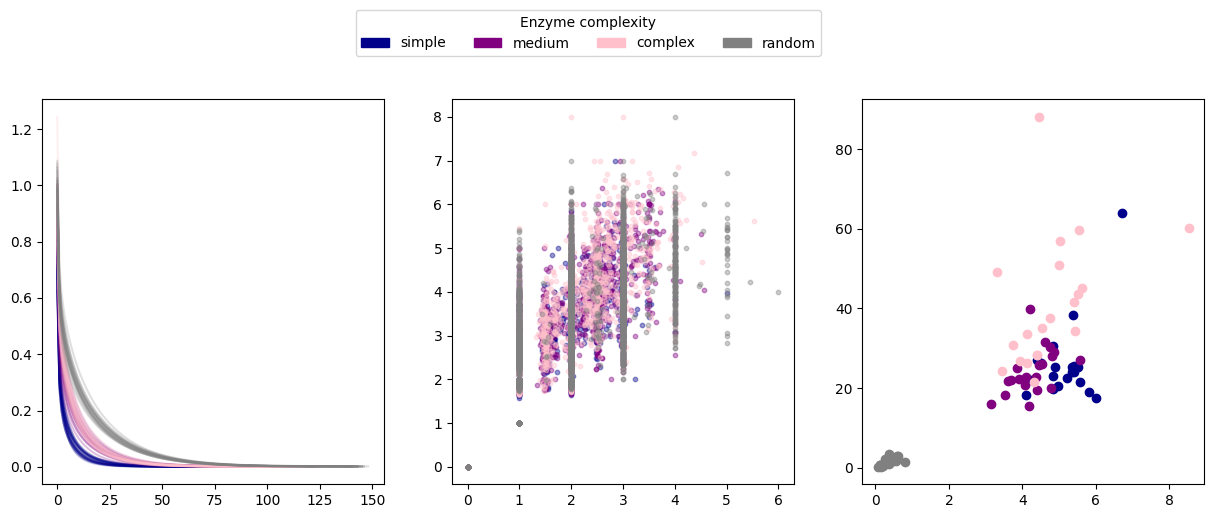

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.estimate_weights(method="alg", n_iterations=500, lr=1)

bmrk.plot(axs[0], ptype="loss", method_name="alg")
bmrk.plot(axs[1], ptype="corr_di", method_name="alg")
bmrk.plot(axs[2], ptype="d", method_name="alg")

--simple---
 49 / 50 | 0.13, kl: 0.13, reg: 0.00  | nz: 434 | 
 Averaged DI: 2.36
 49 / 50 | 0.13, kl: 0.13, reg: 0.00  | nz: 567 | 
 Averaged DI: 2.46
 49 / 50 | 0.10, kl: 0.10, reg: 0.00  | nz: 482 | 
 Averaged DI: 2.40
 49 / 50 | 0.09, kl: 0.09, reg: 0.00  | nz: 582 | 
 Averaged DI: 2.55
 49 / 50 | 0.14, kl: 0.14, reg: 0.00  | nz: 551 | 
 Averaged DI: 2.58
 49 / 50 | 0.12, kl: 0.12, reg: 0.00  | nz: 555 | 
 Averaged DI: 2.63
 49 / 50 | 0.12, kl: 0.12, reg: 0.00  | nz: 411 | 
 Averaged DI: 2.29
 49 / 50 | 0.10, kl: 0.10, reg: 0.00  | nz: 518 | 
 Averaged DI: 2.47
 49 / 50 | 0.09, kl: 0.09, reg: 0.00  | nz: 454 | 
 Averaged DI: 2.52
 49 / 50 | 0.11, kl: 0.11, reg: 0.00  | nz: 473 | 
 Averaged DI: 2.45
 49 / 50 | 0.13, kl: 0.13, reg: 0.00  | nz: 482 | 
 Averaged DI: 2.41
 49 / 50 | 0.06, kl: 0.06, reg: 0.00  | nz: 502 | 
 Averaged DI: 2.42
 49 / 50 | 0.13, kl: 0.13, reg: 0.00  | nz: 439 | 
 Averaged DI: 2.47
 49 / 50 | 0.16, kl: 0.16, reg: 0.00  | nz: 561 | 
 Averaged DI: 2.62
 49 / 50

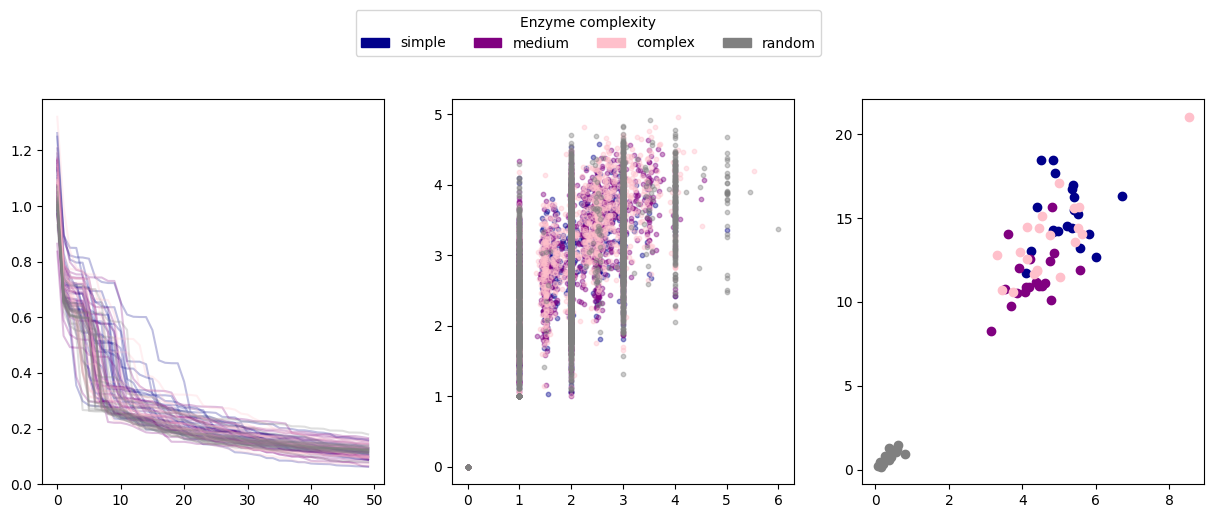

In [ ]:
bmrk.estimate_weights(method="gd", n_iterations=50)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.plot(ax=axs[0], ptype="loss", method_name="gd")
bmrk.plot(ax=axs[1], ptype="corr_di", method_name="gd")
bmrk.plot(ax=axs[2], ptype="d", method_name="gd")

--simple---
 49 / 50 | 2.78, kl: 0.06, reg: 2.73  | nz: 434 | 
 Averaged DI: 2.34
 49 / 50 | 2.90, kl: 0.06, reg: 2.83  | nz: 567 | 
 Averaged DI: 2.44
 49 / 50 | 2.52, kl: 0.04, reg: 2.48  | nz: 482 | 
 Averaged DI: 2.38
 49 / 50 | 3.33, kl: 0.08, reg: 3.25  | nz: 582 | 
 Averaged DI: 2.49
 49 / 50 | 2.82, kl: 0.05, reg: 2.77  | nz: 551 | 
 Averaged DI: 2.57
 49 / 50 | 2.99, kl: 0.04, reg: 2.95  | nz: 555 | 
 Averaged DI: 2.50
 49 / 50 | 2.66, kl: 0.06, reg: 2.60  | nz: 411 | 
 Averaged DI: 2.26
 49 / 50 | 2.61, kl: 0.03, reg: 2.58  | nz: 518 | 
 Averaged DI: 2.32
 49 / 50 | 2.98, kl: 0.08, reg: 2.90  | nz: 454 | 
 Averaged DI: 2.40
 49 / 50 | 2.86, kl: 0.09, reg: 2.77  | nz: 473 | 
 Averaged DI: 2.48
 49 / 50 | 3.16, kl: 0.05, reg: 3.10  | nz: 482 | 
 Averaged DI: 2.29
 49 / 50 | 3.00, kl: 0.10, reg: 2.90  | nz: 502 | 
 Averaged DI: 2.32
 49 / 50 | 2.47, kl: 0.04, reg: 2.43  | nz: 439 | 
 Averaged DI: 2.35
 49 / 50 | 3.19, kl: 0.13, reg: 3.05  | nz: 561 | 
 Averaged DI: 2.49
 49 / 50

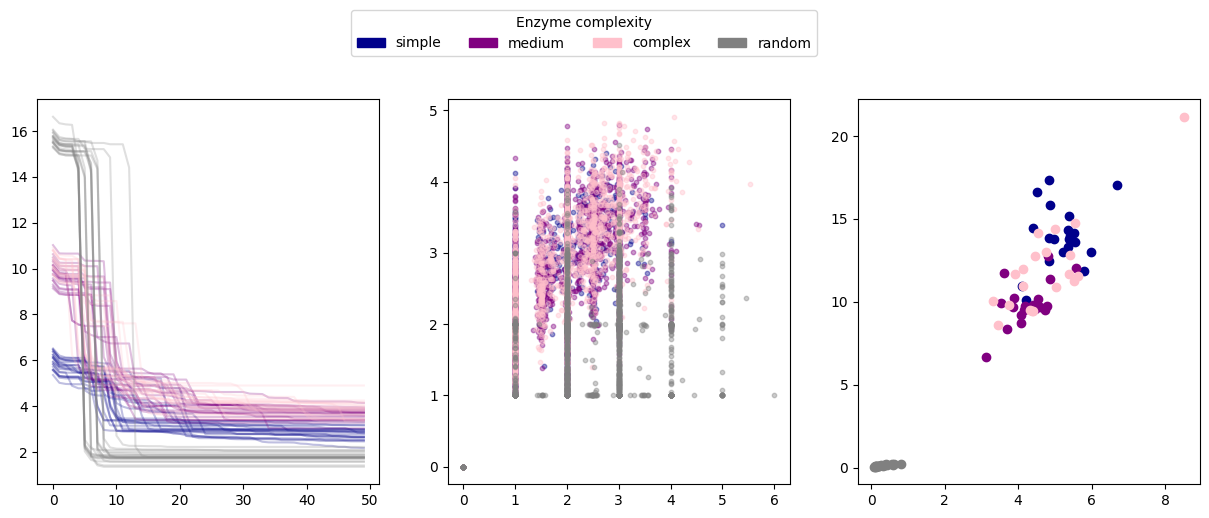

In [ ]:
bmrk.estimate_weights(method="gd", lam1=0.1, n_iterations=50, method_name="gd_l1")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.plot(ax=axs[0], ptype="loss", method_name="gd_l1")
bmrk.plot(ax=axs[1], ptype="corr_di", method_name="gd_l1")
bmrk.plot(ax=axs[2], ptype="d", method_name="gd_l1")

--simple---
 1 / 50 | 2.49, kl: 0.95, reg: 1.55  | nz: 434 | 

 49 / 50 | 0.70, kl: 0.06, reg: 0.63  | nz: 434 | 
 Averaged DI: 2.37
 49 / 50 | 0.68, kl: 0.08, reg: 0.60  | nz: 567 | 
 Averaged DI: 2.47
 49 / 50 | 0.50, kl: 0.03, reg: 0.47  | nz: 482 | 
 Averaged DI: 2.42
 49 / 50 | 0.60, kl: 0.04, reg: 0.56  | nz: 582 | 
 Averaged DI: 2.55
 49 / 50 | 0.62, kl: 0.07, reg: 0.55  | nz: 551 | 
 Averaged DI: 2.57
 49 / 50 | 0.67, kl: 0.07, reg: 0.59  | nz: 555 | 
 Averaged DI: 2.52
 49 / 50 | 0.62, kl: 0.07, reg: 0.55  | nz: 411 | 
 Averaged DI: 2.27
 49 / 50 | 0.60, kl: 0.08, reg: 0.52  | nz: 518 | 
 Averaged DI: 2.43
 49 / 50 | 0.64, kl: 0.03, reg: 0.61  | nz: 454 | 
 Averaged DI: 2.39
 49 / 50 | 0.62, kl: 0.07, reg: 0.55  | nz: 473 | 
 Averaged DI: 2.55
 49 / 50 | 0.60, kl: 0.05, reg: 0.55  | nz: 482 | 
 Averaged DI: 2.36
 49 / 50 | 0.61, kl: 0.05, reg: 0.55  | nz: 502 | 
 Averaged DI: 2.38
 49 / 50 | 0.48, kl: 0.05, reg: 0.43  | nz: 439 | 
 Averaged DI: 2.39
 49 / 50 | 0.71, kl: 0.06, reg: 0.65  | nz: 561 | 
 Averaged DI: 2.53
 49 / 50 | 0.46, kl:

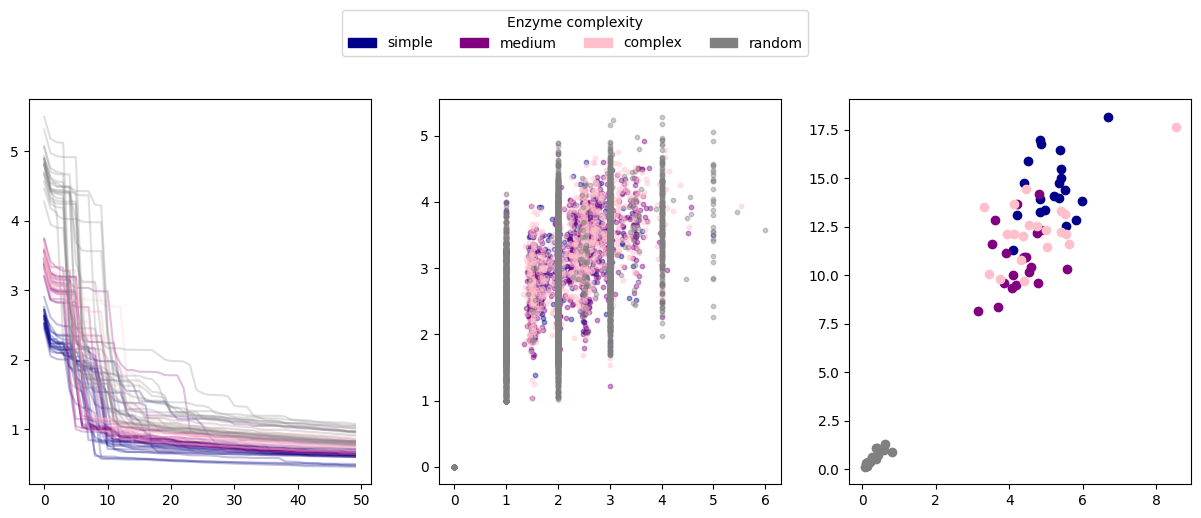

In [ ]:
bmrk.estimate_weights(method="gd", lam2=0.1, n_iterations=50, method_name="gd_l2")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.plot(ax=axs[0], ptype="loss", method_name="gd_l2")
bmrk.plot(ax=axs[1], ptype="corr_di", method_name="gd_l2")
bmrk.plot(ax=axs[2], ptype="d", method_name="gd_l2")

--simple---
Iteration: 0
	V: 26.51 | 25.89
	I: 26.37 | 25.89
	L: 27.26 | 25.89
	E: 26.87 | 25.89
	Q: 26.97 | 25.89
	D: 27.10 | 25.89
	N: 25.97 | 25.89
	H: 27.13 | 25.89
	W: 26.18 | 25.89
	F: 26.46 | 25.89
	Y: 26.25 | 25.89
	R: 27.14 | 25.89
	K: 23.02 | 25.89
K better!
	K: 17.61 | 23.02
K better!
	K: 16.29 | 17.61
K better!
	K: 15.02 | 16.29
K better!
	K: 13.28 | 15.02
K better!
	K: 13.89 | 13.28
	S: 16.50 | 13.28
	T: 17.69 | 13.28
	M: 13.75 | 13.28
	A: 18.16 | 13.28
	G: 18.32 | 13.28
	P: 18.15 | 13.28
	C: 14.93 | 13.28
 exo: 14.31 | 13.51 (0.20)
 exo: 15.11 | 13.51 (0.20)
 exo: 14.47 | 13.51 (0.20)
 exo: 14.54 | 13.51 (0.20)
 exo: 13.31 | 13.31 (0.25)
 exo: 14.29 | 13.31 (0.25)
 exo: 18.81 | 13.31 (0.25)
 exo: 15.29 | 13.31 (0.25)
 exo: 14.52 | 13.31 (0.25)
 exo: 11.92 | 11.92 (0.30)
 49 / 50 | 0.12, kl: 0.12, reg: 0.00  | nz: 431 | 
 Averaged DI: 2.57
Iteration: 0
	V: 27.11 | 26.39
	I: 25.93 | 26.39
I better!
	I: 26.65 | 25.93
	L: 27.14 | 25.93
	E: 26.61 | 25.93
	Q: 26.75 | 25.93
	D: 

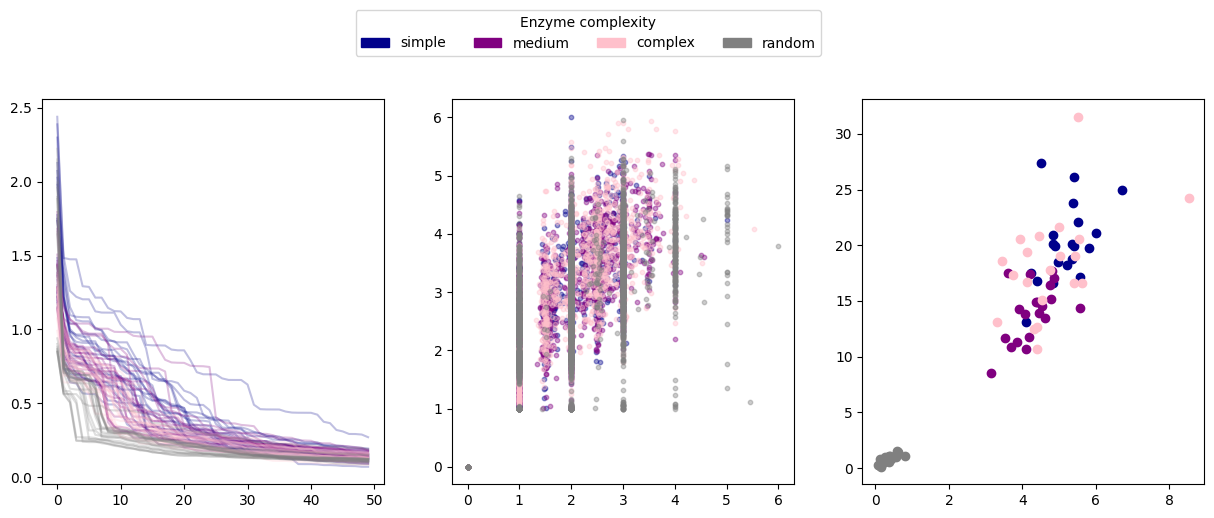

In [ ]:
bmrk.estimate_weights(
    method="gd",
    n_iterations=50,
    lam1=0,
    lam2=0,
    parameter_estimator=True,
    method_name="gd_param",
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.plot(ax=axs[0], ptype="loss", method_name="gd_param")
bmrk.plot(ax=axs[1], ptype="corr_di", method_name="gd_param")
bmrk.plot(ax=axs[2], ptype="d", method_name="gd_param")

<Axes: xlabel='enzyme', ylabel='d'>

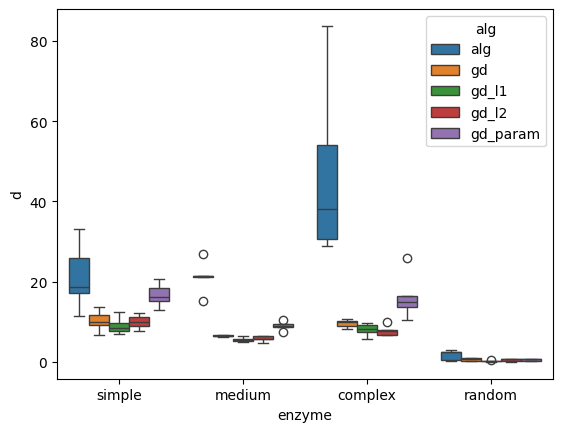

In [ ]:
import pandas as pd
import numpy as np

df = {"alg": [], "enzyme": [], "d": []}
for alg in bmrk.results.keys():
    if alg == "real":
        continue
    for enzyme_name in enzyme_names:
        for iteration in range(5):
            df["alg"].append(alg)
            df["enzyme"].append(enzyme_name)
            df["d"].append(
                np.abs(
                    bmrk.results["real"][enzyme_name][iteration]["d"]
                    - bmrk.results[alg][enzyme_name][iteration]["d"]
                )
            )
df = pd.DataFrame(df)
import seaborn as sns

sns.boxplot(df, x="enzyme", y="d", hue="alg")

# Peptidomes

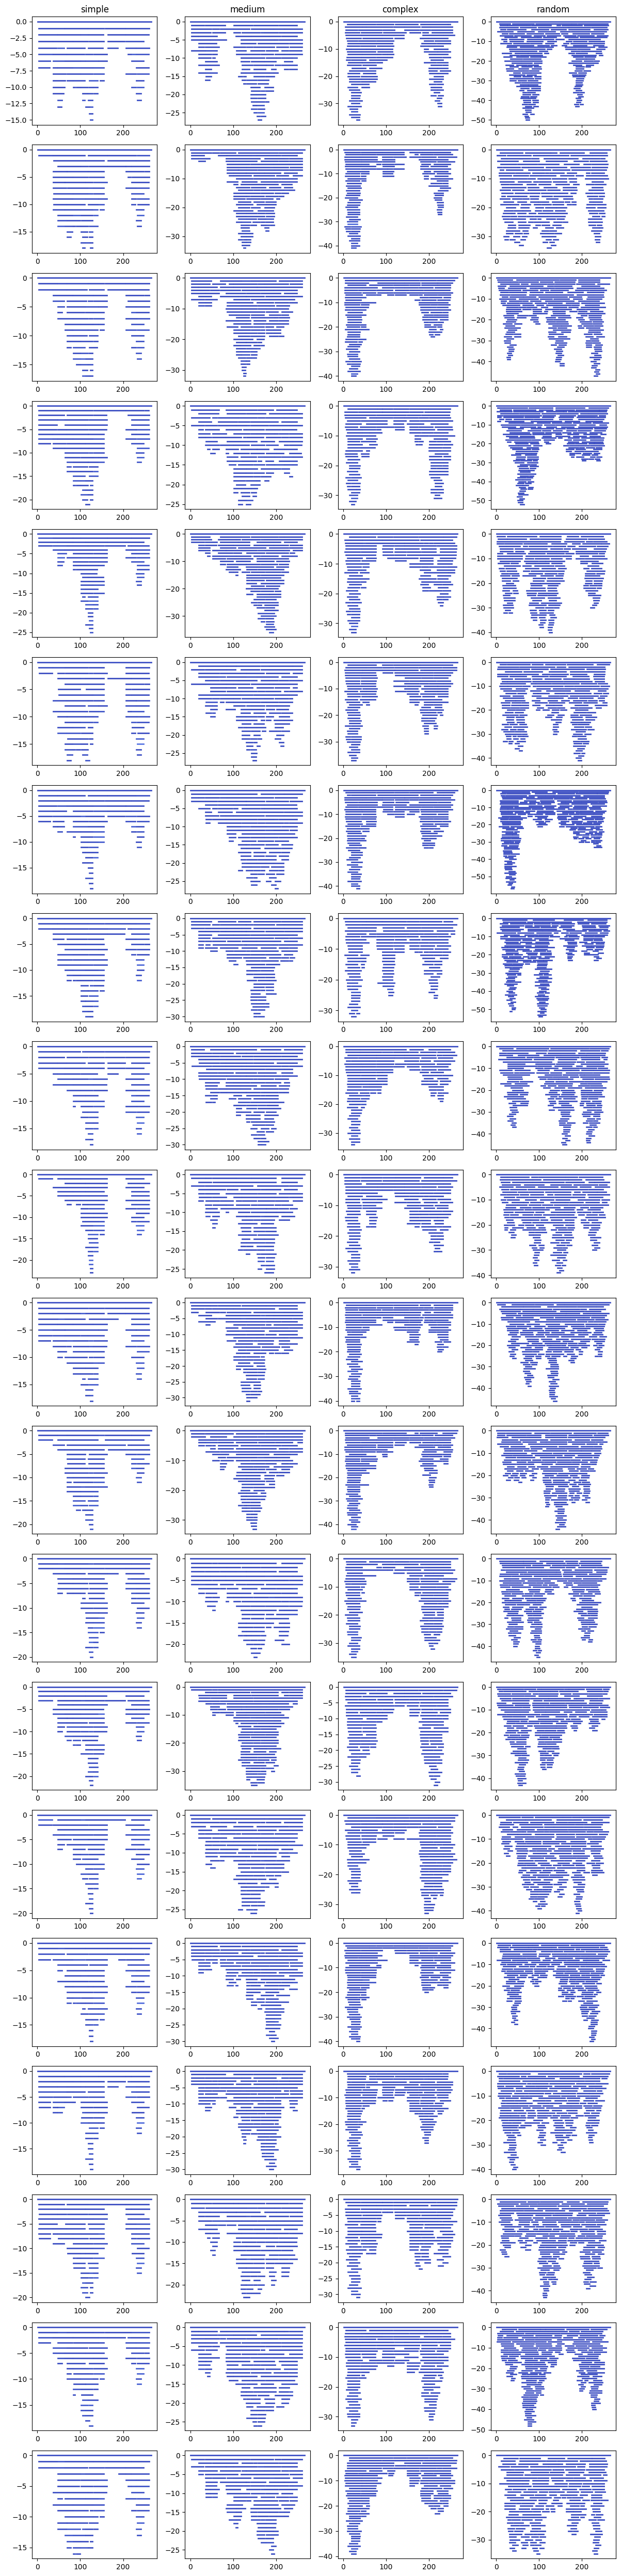

In [ ]:
from disassembly.util import plot_peptidome

fig, axs = plt.subplots(
    bmrk.iterations,
    len(bmrk.enzyme_names),
    figsize=(len(bmrk.enzyme_names) * 3, bmrk.iterations * 2.5),
)
for iteration in range(bmrk.iterations):
    for test_name in bmrk.enzyme_names:
        ax = axs[iteration, bmrk.enzyme_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, bmrk.simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()